---
title: Visualizing Text with NLTK and CountVectorizer
tags: [ Data Visualization, Natural Language Processing (NLP), AWS S3 ]
---

As an Excel user myself, textual or non-numeric data always felt beyond my reach in the tiny rectangular cells within a spreadsheet. Today, we explore how tokenization of text can be executed in Python to generate numerical insights from the text elements within 40,000 food recipes scraped from [Allrecipes](www.allrecipes.com). 

# Goal

# Overview of Setup

## Docker Environments

To replicate the environment used to perform this analysis:
1. fork the Github [repository](https://github.com/andrewyewcy/recipe_classifier) locally on a Docker and Docker-compose installed machine
2. run below line in Terminal within the file directory of the repository

In [1]:
# Run below line in terminal within the folder that contains the forked repo
# docker-compose -f dev_setup.yaml up

Instructions on how to access Jupyter will be generated in the Terminal. Detailed installation documentation can be found within the README of the repository. 

## Import Packages and Define Functions

The [`natural language toolkit(NLTK)`](https://www.nltk.org/) and the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) within `scikit-learn` were used to process and transform the recipe text into tokens which can be quantified numerically for analysis.

In [2]:
# Packages for general data processing
import numpy as np
import pandas as pd
import joblib       # Loading data
import time         # Measuring time
import ast          # Reading lists within pandas DataFrame

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from notebook_functions.plot import plot_histogram # Custom function to plot distribution

# Packages for pre-processing text
import nltk                       # Natural Language Tool Kit
nltk.download('stopwords')        # For processing stop words (words too common to hold significant meaning)
from nltk.corpus import stopwords # Import above downloaded stopwords
import re                         # Regular Expression
import string                     # For identifying punctuation

# Packages for processing text
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import Data From AWS S3

The data was stored in an AWS Simple, Storage, Service (S3) bucket, which is a cloud storage service that integrates well with other AWS applications like EC2 and EMR. 

The data contains the various numerical and textual elements of 40,000 recipes web-scraped of Allrecipes between the months of February and March 2023.

### Insert image of data here

In [3]:
df = joblib.load(
    "../data/raw_data_df.pkl"
)

In [4]:
print(f"There are {df.shape[0]} recipes with {df.shape[1]} columns.")

There are 40001 recipes with 18 columns.


The main columns of interest are the `recipe_url`, `titles`, `label`, `rating_average`, and `rating_count`.

In [5]:
columns_of_interest = [
    "recipe_url",
    "title",
    "label",
    "rating_average",
    "rating_count"
]

# Filter for columns of interest 
df = df.loc[:,columns_of_interest]

# Visually examine the filtered data
df.head(1).T

,0
recipe_url,https://www.allrecipes.com/recipe/83646/corned...
title,Corned Beef Roast
label,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee..."
rating_average,4.4
rating_count,68


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40001 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      40001 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


Data Dictionary:

| Column | Type | Description |
|---|---|---|
| `recipe_url` | hyperlink | The uniform resource locator(URL) that leads to the recipe hosted on Allrecipes.com |
| `title` | text | The title of each recipe |
| `label` | text | The labels (tags) for each recipe. Used by Allrecipes.com as a method of organizing recipes |
| `rating_average` | float | The rounded average as found on each recipe on Allrecipes.com |
| `rating_count` | integer | The number of ratings for each recipe |

Issues with the loaded data:
1. The `rating_count` column was found to be of `object` type instead of `int`.
2. Null values observed for `title`, `label`, `rating_average`,and `rating_count`.

# Data Cleaning and EDA

## Null `titles`

In [7]:
# Examine null titles
cond = df['title'].isnull()

print(f"Number of null titles: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of recipes")

# Visually examine null titles
df.loc[cond]

Number of null titles: 7, 0.02% of recipes


,recipe_url,title,label,rating_average,rating_count
22785,https://www.allrecipes.com/cook/thedailygourme...,NaN,NaN,NaN,NaN
23968,https://www.allrecipes.com/recipe/14759/pork-d...,NaN,NaN,NaN,NaN
26010,https://www.allrecipes.com/recipe/218445/lenge...,NaN,NaN,NaN,NaN
26389,https://www.allrecipes.com/recipe/cajun-spice-...,NaN,NaN,NaN,NaN
26848,https://www.allrecipes.com/recipe/herman-sourd...,NaN,NaN,NaN,NaN
27388,https://www.allrecipes.com/recipe/mustard-pork...,NaN,NaN,NaN,NaN
33171,https://www.allrecipes.com/recipe/biga/detail....,NaN,NaN,NaN,NaN


As the adherence of each recipe to a standard structure was not well understood, it was assumed that these recipes maybe published with some error and thus excluded from analysis.

In [8]:
# Drop rows with null titles
df = df.loc[~cond]

In [9]:
# Examine null values again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39994 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      39994 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.8+ MB


## Null `rating_average` and `rating_count`

In [10]:
# Try to convert the `rating_count` column to integer
try:
    df['rating_count'].astype('int')
except ValueError as e:
    print(f"{str(e)}")

invalid literal for int() with base 10: '2,630'


It would appear that thousands are separated with a comma, leading to the error in type conversion.

In [11]:
# Remove comma from `rating_count`, then fill NaN with 0 for conversion to integer
try:
    df['rating_count'] = df['rating_count'].str.replace(",","").fillna(0).astype('int')
except ValueError as e:
    print(f"{str(e)}")

In [12]:
# Examine the converted rating_count
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39994 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      39994 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    39994 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


Note the recipes with previously null rating counts were now filled with 0, which makes sense since no rating is equal to 0 ratings.

In [13]:
# Drop the recipes with null rating_average
cond = df['rating_average'].isnull()

print(f"Number of null titles: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of recipes")

# Visually examine null titles
df.loc[cond].head()

Number of null titles: 3574, 8.94% of recipes


,recipe_url,title,label,rating_average,rating_count
123,https://www.allrecipes.com/recipe/8538705/tate...,Tater Tot Hotdish,"['Main Dishes', 'Casserole Recipes', 'Vegetabl...",NaN,0
188,https://www.allrecipes.com/recipe/8493351/grai...,Grain-Free Broccoli Fritters,"['Recipes', 'Fruits and Vegetables', 'Vegetabl...",NaN,0
260,https://www.allrecipes.com/recipe/8499644/chic...,Chicken Minestrone Soup,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0
261,https://www.allrecipes.com/recipe/8532495/roas...,Roasted Broccoli Soup,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0
263,https://www.allrecipes.com/recipe/8448142/wate...,Watermelon Tomato Gazpacho with a Cool Cucumbe...,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0


In [14]:
# Drop ropws where the rating_average is null
df = df.loc[~cond]

In [15]:
# Check for any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36420 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      36420 non-null  object 
 1   title           36420 non-null  object 
 2   label           36420 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ MB


All null values have been removed.

## Distribution of `rating_average` and `rating_count`

===== Distribution Plots for rating_average =====


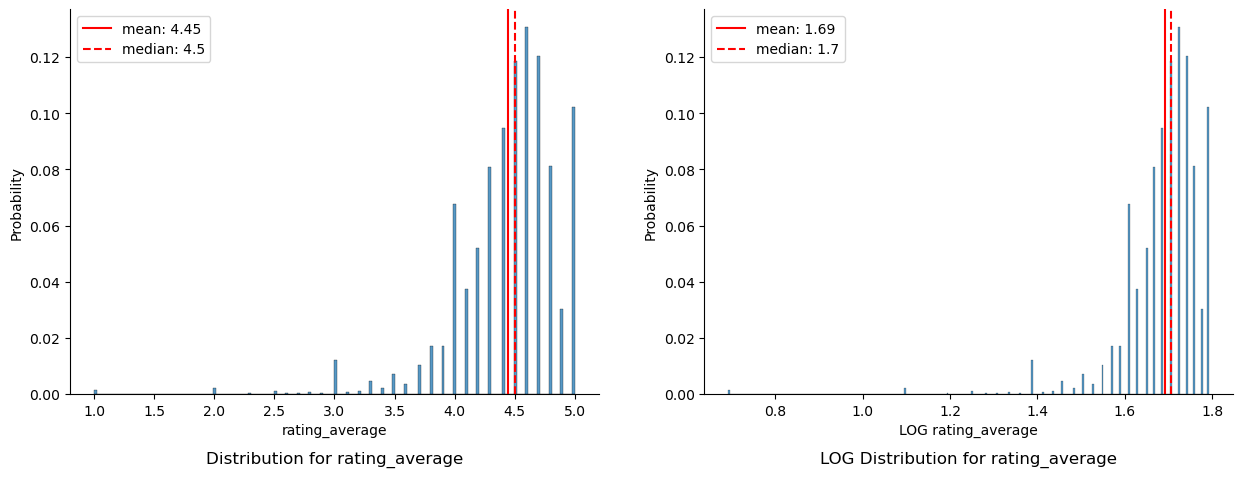



===== Distribution Plots for rating_count =====


<Figure size 640x480 with 0 Axes>

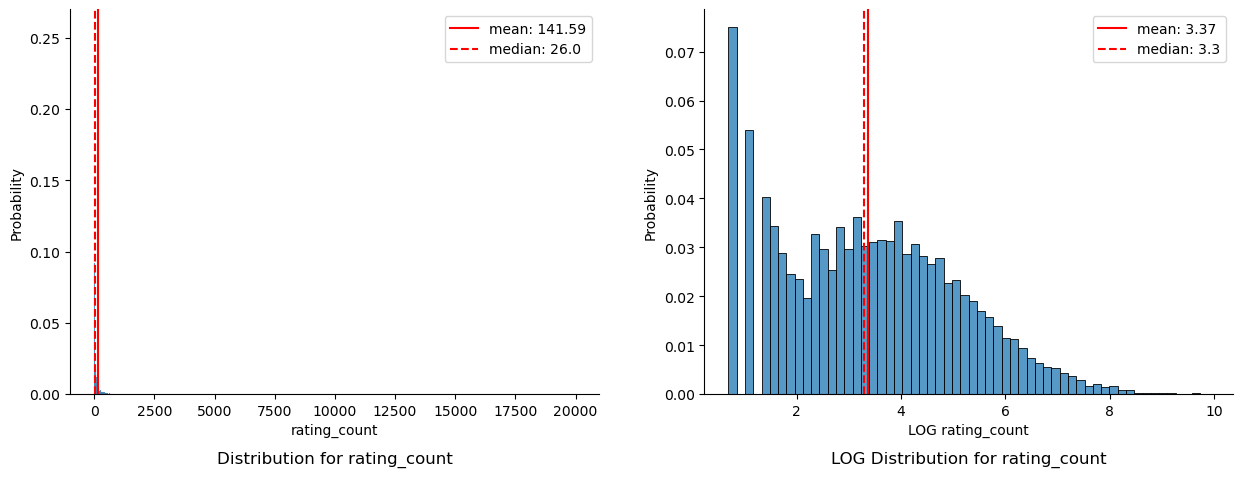

<Figure size 640x480 with 0 Axes>

In [16]:
for col in ["rating_avera ge","rating_count"]:
    plot_histogram(df, col, col,"../assets/images")

A left skew was observed for `rating_average`, with all 40,000 recipes having a mean average rating of 4.5 out of 5. Although the close mean and median suggest a distribution with a single peak, visual observation suggests multiple peaks centered around 4.0, 4.5 and 5.0 respectively. These observations suggest that users who provide ratings tend to provide high ratings of 4 to 5 stars, and, that the `rating_average` may be an over-positive representation of recipes posted on allrecipes.

`Rating_count` was observed to have an extremely right skew, with the mean of 142 ratings per recipe being 5 times greater than the median of 26 ratings per recipe. The skew is mostly caused by outlier recipes with over 10,000 user ratings. This may suggest that the promotion or recommendation of recipes on allrecipes.com highly favours recipes already popular, or that some recipes are so common that many people search for it. Further detailed exploration by recipe is required to verify this. The LOG of the `rating_count` reduces the effect of outliers and reveals a bimodal distirbution. The taller peak of the left suggests most recipes tend to have low rating counts, with a smaller peak representing the next majority of recipes centered around 1,000 ratings per recipe.

## Recipes with Less than 2 ratings

The significance of recipe ratings are dependent on the number of ratings. Thus, to ensure some standard of quality for recipes, recipes with less than 2 ratings were excluded from analysis. The number of 2 was chosen based on the assumption that a second independent rating raises the validity of the recipe rating.

In [19]:
# Identify the number of recipes with less than 2 ratings
cond = df["rating_count"] < 2

print(f"Number of recipes with less than 2 ratings: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of recipes")

# Visual examination of these recipes
df.loc[cond].head()

Number of recipes with less than 2 ratings: 2729, 7.49% of recipes


,recipe_url,title,label,rating_average,rating_count
2,https://www.allrecipes.com/recipe/8509102/chic...,Chicken Al Pastor,"['Mexican', 'Main Dishes', 'Tacos', 'Chicken']",5.0,1
186,https://www.allrecipes.com/recipe/8532964/air-...,Air Fryer Tilapia,"['Recipes', 'Seafood', 'Fish', 'Tilapia']",5.0,1
189,https://www.allrecipes.com/recipe/8441918/skil...,Skillet Zucchini and Squash,"['Vegetables', 'Squash', 'Summer Squash', 'Yel...",5.0,1
190,https://www.allrecipes.com/recipe/8499615/air-...,Air Fryer Scrambled Eggs On The Go,"['Recipes', 'Breakfast and Brunch', 'Eggs', 'S...",4.0,1
262,https://www.allrecipes.com/recipe/8532956/dump...,Dump-and-Go Instant Pot Tortilla Soup,"['Recipes', 'Soups, Stews and Chili Recipes', ...",4.0,1


===== Distribution Plots for rating_average =====


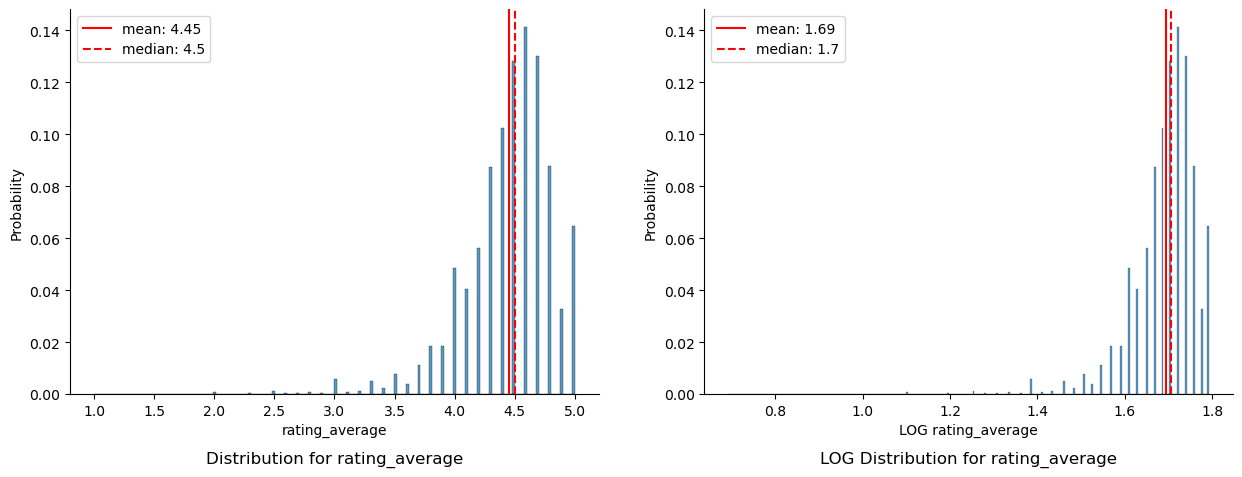



===== Distribution Plots for rating_count =====


<Figure size 640x480 with 0 Axes>

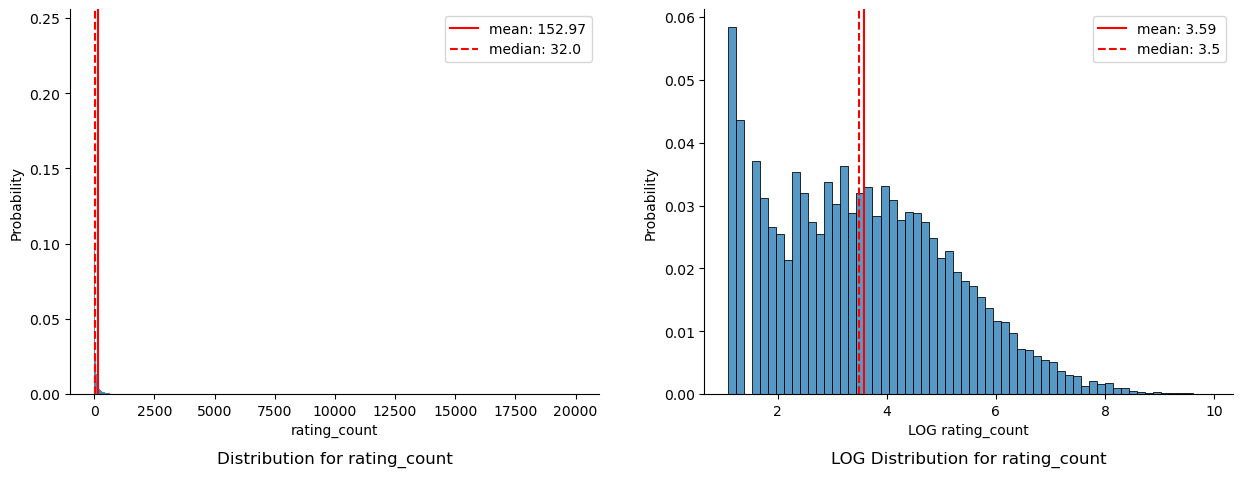

<Figure size 640x480 with 0 Axes>

In [21]:
for col in ["rating_average","rating_count"]:
    plot_histogram(df.loc[~cond], col, col,"../assets/images")

Although 7.49% of the remaining recipes contain less than 2 ratings, the validity of the quality of the recipes being analyzed is deemed more important than the number of recipes analyzed, and thus these 2,729 recipes were dropped from analysis. Further backing up this decision, the distribution of `rating_count` and `rating_average` were observed to be unchanged after removing recipes with less than 2 ratings.

In [22]:
# Drop ropws where the recipe has less than 2 ratings
df = df.loc[~cond]

In [23]:
# Examine remaining recipes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33691 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      33691 non-null  object 
 1   title           33691 non-null  object 
 2   label           33691 non-null  object 
 3   rating_average  33691 non-null  float64
 4   rating_count    33691 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [24]:
# Numerical examination of cleaned distribution
df.describe()

,rating_average,rating_count
count,33691.000000,33691.000000
mean,4.451895,152.973316
std,0.381909,538.782772
min,1.000000,2.000000
25%,4.300000,9.000000
50%,4.500000,32.000000
75%,4.700000,108.000000
max,5.000000,19961.000000


# Text Preprocessing

First, the column containg the labels of each recipe were examined.

In [30]:
# As only 5 rows were examined, the slower iterrows method was used for code simplicity
for index, row in df.loc[:,["title", "label"]].head().iterrows():
    print(f"{row[0]} has labels:    {row[1]}")

Corned Beef Roast has labels:    ['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']
Stout-Braised Lamb Shanks has labels:    ['Cuisine', 'European', 'UK and Ireland', 'Irish']
Mississippi Chicken has labels:    ['Recipes', 'Meat and Poultry', 'Chicken']
Lasagna Flatbread has labels:    ['Recipes', 'Bread', 'Quick Bread Recipes']
Prosciutto-Wrapped Pork Tenderloin with Crispy Sage has labels:    ['Recipes', 'Meat and Poultry', 'Pork', 'Pork Tenderloin Recipes']


The labels for each recipe were observed to be a list of terms separated by commas. Furthermore, the number of labels and the labels themselves are not consistent across recipes. Common words such as "Recipes" were observed to bring no analysis value as each row represents a recipe by default. 

As such, before vectorizing the recipe labels into a sparse table containing a count for each vector, preprocessing of text shold be performed to ensure that only meaningful labels are included. In other words, the text column containing recipe labels must be cleaned.

To facilitate systematic cleaning of each recipe's text, a `tokenizer` will be built, with the recipe `Corned Beef Roast` being the recipe evaluated as the tokenizer is built.

In [43]:
# Visually examine the labels of Corned Beef Roast, which is index 0
sentence = df.loc[0,"label"]
print(sentence)

['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']


## Remove Punctuation

To get a list of punctuation to remove, the punctuation attribute of the `string` module was accessed.

In [44]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Removing the punctuation from the labels of Corned Beef Roast leads to each word being separated by space. Although cleaner, this is not ideal the words `main` and `dishes` make more sense together than when evaluated separately. 

In [45]:
# Remove punctuation and change to lower case
for punctuation_mark in string.punctuation:
    sentence = sentence.replace(punctuation_mark, "").lower()

print(sentence)

recipes main dishes beef corned beef recipes


One option is to use the `n-grams` option in the `CountVectorizer` later. However, since the inclusion of n-grams significantly increases the number of tokens formed, combined with the simplicity of the text, a custom word-combiner was used instead to remove punctuation to generate more meaning. Regular Expression ([regex](https://docs.python.org/3/library/re.html)) was used to specify which punctuation to remove.

In [47]:
# Regenerate Corned Beef Roast labels
sentence = df.loc[0,"label"]

# STEP 1: Replace all spaces after commas with placeholder "+"
sentence = re.sub(",\s","+",sentence)
print(f"STEP1: {sentence}")

# STEP 2: Replace all other spaces within quotation marks with "_"
sentence = re.sub("\s","_",sentence)
print(f"STEP2: {sentence}")

# STEP 3: Revert the placeholder to back to original space to separate labels
sentence = sentence.replace("+",", ")
print(f"STEP3: {sentence}")

# STEP 4: Finally, remove all punctuation except "_"
for punctuation_mark in [punctuation for punctuation in string.punctuation if punctuation != "_"]:
    sentence = sentence.replace(punctuation_mark,"").lower()

print(f"STEP4: {sentence}")

STEP1: ['Recipes'+'Main Dishes'+'Beef'+'Corned Beef Recipes']
STEP2: ['Recipes'+'Main_Dishes'+'Beef'+'Corned_Beef_Recipes']
STEP3: ['Recipes', 'Main_Dishes', 'Beef', 'Corned_Beef_Recipes']
STEP4: recipes main_dishes beef corned_beef_recipes


Now, as seen in step 4 above, all other punctuation marks have been removed while preserving meaningful word combinations for recipe labels.

## Remove Numbers

Similar to punctuation, the `digits` attribute of the `string` module can be used to remove digits. In this specific context of recipe labels, numerical digits do not hold much meaning and were thus removed.

In [48]:
# Examing numerical digits to be removed
print(string.digits)

0123456789


The `maketrans()` method was used as a faster alternative to looping through each character.

In [49]:
# Each digit within string.digits is mapped to None
remove_digits = str.maketrans('','', string.digits)

# Apply mapping to sentence
sentence = sentence.translate(remove_digits)

print(sentence)

recipes main_dishes beef corned_beef_recipes


As expected, no changes were observed since no numerical digits were present in the example. To prove that numerical digits are being removed, the below simple test case was created:

In [50]:
# Example with numbers inside
test_sentence = "recipes main_dishes11111 beef2222 corned_beef_recipes"
print(f"Test with numbers: {test_sentence}")

# Apply mapping to remove digits to test sentence
test_sentence = test_sentence.translate(remove_digits)

print(test_sentence)

Test with numbers: recipes main_dishes11111 beef2222 corned_beef_recipes
recipes main_dishes beef corned_beef_recipes


## Remove Stop Words + Stemming

Stop Words refer to words that are so commonly used that they hold no significant meaning aside. To access a list of English stopwords was access through the NLTK corpus, and further extended to include words specific to this use case.

In [55]:
# Examine first 10 stopwords in enlish
eng_stopwords = stopwords.words('english')
print(eng_stopwords[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [56]:
# Extending the list of stopwords
print(f"")

# some stop words in food recipes
eng_stopwords.extend(['degree','degrees','c','f', 'recipe', 'recipes', 'minute', 'minutes'])

After defining stop words to exclude from analysis, the variant of each word can be standardized using stemming. Note that each sentence was broken up into words based on whitespaces as meaningful combinations of words were already accounted for when removing punctuation.

In [57]:
# Define a stemmer
stemmer = nltk.stem.PorterStemmer()

In [58]:
print(f"Before stemming and stop word removal:    {sentence}")

# Split sentence into words based on spaces
list_of_words = sentence.split(' ')

# Define blank list to store stemmed words
list_of_stemmed_words = []

for word in list_of_words:
    
    # Remove stop words and and any tokens that are just empty strings
    if (not word in eng_stopwords) and word != "":

        # Stem each word
        list_of_stemmed_words.append(stemmer.stem(word))

# Examine sentence after stemming and stop word removal
print(f"After stemming and stop word removal:    {list_of_stemmed_words}")

Before stemming and stop word removal:    recipes main_dishes beef corned_beef_recipes
After stemming and stop word removal:    ['main_dish', 'beef', 'corned_beef_recip']


As expected, the word `recipes` was removed since it was defined as a stop word. The stemming worked as expected as the plurality of `main_dishes` was removed, leaving `main_dish`. Stemming is not a perfect process as `corned_beef_recipes` was stemmed to `corned_beef_recip`. 

## Compiling into a tokenizer function

The above text preprocessing steps were combined into a function to be applied to each recipe. 

In [81]:
def tokenizer(sentence):
    """
    This function performs the tokenization of text with below steps:
    1) removes punctuation and combines meaningful labels with underscore
    2) removes numerical digits
    3) splits a sentence into words based on white space
    4) removes stop words
    5) apply PorterStemmer to each word

    ======
    INPUTS
    ======
    sentence: a string object to be tokenized

    =======
    OUTPUTS
    =======
    stemmed_tokens: a list of stemmed tokens

    =======
    EXAMPLE
    =======
    Given:
    sentence = "['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']"
    print(type(sentence))
    >>> str
    
    tokens = tokenizer(sentence)
    print(tokens)
    >>> ['main_dish', 'beef', 'corned_beef_recip']
    
    print(type(tokens))
    >>> list
    """

    assert isinstance(sentence,str), "Passed object is not string"
    
    # Define variables
    punctuation_to_remove = [punctuation for punctuation in string.punctuation if punctuation != "_"]
    digits_to_remove      = string.digits
    stemmer               = nltk.stem.PorterStemmer()
    stemmed_tokens        = [] # Initiate blank link for storing tokens
    eng_stopwords         = stopwords.words('english')
    eng_stopwords.extend(['degree','degrees','c','f', 'recipe', 'recipes', 'minute', 'minutes', 'cuisine','cuisines'])
    
    # Remove punctuation and combine meaningful words
    sentence = re.sub(",\s","+",sentence) # STEP 1: Replace all spaces after commas with placeholder "+"
    sentence = re.sub("\s","_",sentence)  # STEP 2: Replace all other spaces within quotation marks with "_"
    sentence = sentence.replace("+",", ") # STEP 3: Revert the placeholder to back to original space to separate labels
    for punctuation_mark in punctuation_to_remove:
        sentence = sentence.replace(punctuation_mark,"").lower()

    # Remove numerical digits using mapper
    remove_digits_mapper = str.maketrans('','', digits_to_remove)
    sentence = sentence.translate(remove_digits_mapper)

    # Split sentence into individual tokens
    tokens = sentence.split(' ')

    for token in tokens:
        # Remove stop words and and any tokens that are just empty strings
        if (not token in eng_stopwords) and token != "":
            # Stem each token
            stemmed_tokens.append(stemmer.stem(token))

    return stemmed_tokens

In [82]:
# Testing the function
sentence = df.loc[0,"label"]
print(f"Recipe labels before tokenization:    {sentence}")

# Apply the tokenizer
tokens = tokenizer(sentence)
print(f"Recipe labels after tokenization:    {tokens}")

Recipe labels before tokenization:    ['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']
Recipe labels after tokenization:    ['main_dish', 'beef', 'corned_beef_recip']


The tokenizer works as expected.

# CountVectorizor

## Testing with 2 recipes

Now that a consistent method of preprocessing text into tokens has been established, the tokens can be quantified by simply counting the frequency of tokens in each recipe.

In [83]:
# Define a CountVectorizer model
bagofwords = CountVectorizer(
    tokenizer = tokenizer
)

# Tell the Vectorizer what tokens there are by fitting it to the first two recipes for testing
bagofwords.fit(df["label"].head(2))

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(tokenizer=<function tokenizer at 0x7f0686810360>)

In [86]:
# Use the fitted vectorizer to transform labels into tokens
labels_transformed = bagofwords.transform(df["label"].head(2))

# Examine the data type
print(type(labels_transformed))

<class 'scipy.sparse._csr.csr_matrix'>


The output of the vectorizer is a sparse matrix, which is a compressed form of data storage used for optimizing file size when the data contains many zero values. To examine the output, the sparse matrix must first be converted back to a DataFrame.

In [87]:
# Convert the vectorized labels from a sparse matrix object into a DataFrame
vectorized_labels = pd.DataFrame(
    labels_transformed.toarray(),
    columns = bagofwords.get_feature_names_out()
)

# Combine the vectors with the original DataFrame for examination
pd.concat(
    [
        df[["title", "label"]].head(2),
        vectorized_labels
    ],
    axis = 1
)

,title,label,beef,corned_beef_recip,european,irish,main_dish,uk_and_ireland
0,Corned Beef Roast,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee...",1,1,0,0,1,0
1,Stout-Braised Lamb Shanks,"['Cuisine', 'European', 'UK and Ireland', 'Iri...",0,0,1,1,0,1


The CountVectorizer vectorized the recipe labels into counts of tokens. Note that the number of tokens is dependent on the recipes used to fit the vectorizer. This means that if a new recipe that contains entirely new tokens were fed to the same pre-trained vectorizer, an entire row of zeros would be observed and no new tokens will be added.

## All Recipes Vectorized

In [90]:
# Define a CountVectorizer model
label_vectorizer_001 = CountVectorizer(
    tokenizer = tokenizer
)

# Fit and Transform the recipe labels using the CountVectorizer
sparse_labels = label_vectorizer_001.fit_transform(df["label"])

In [91]:
vectorized_labels = pd.DataFrame(
    sparse_labels.toarray(),
    columns = label_vectorizer_001.get_feature_names_out()
)

In [92]:
print(f"There are {vectorized_labels.shape[1]} tokens for {vectorized_labels.shape[0]} recipes.")

There are 1196 tokens for 33691 recipes.


In [93]:
vectorized_labels.iloc[0:5, 0:5]

,_layer_dip_recip,acorn_squash,acorn_squash_side_dish_recip,adult_punch_recip,african
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


# Visual Analysis

## Top 20 Recipe Labels

In [107]:
vectorized_labels.sum().sort_values(ascending = False).head(20)

dessert                  6527
side_dish                4200
main_dish                3661
meat_and_poultri         2476
soup                     2473
stews_and_chili_recip    2471
appetizers_and_snack     2463
salad                    1814
chicken                  1800
bread                    1791
veget                    1760
sauces_and_condi         1716
soup_recip               1712
breakfast_and_brunch     1619
cooki                    1557
european                 1231
cake                     1226
drinks_recip             1164
pork                     1106
quick_bread_recip        1070
dtype: int64

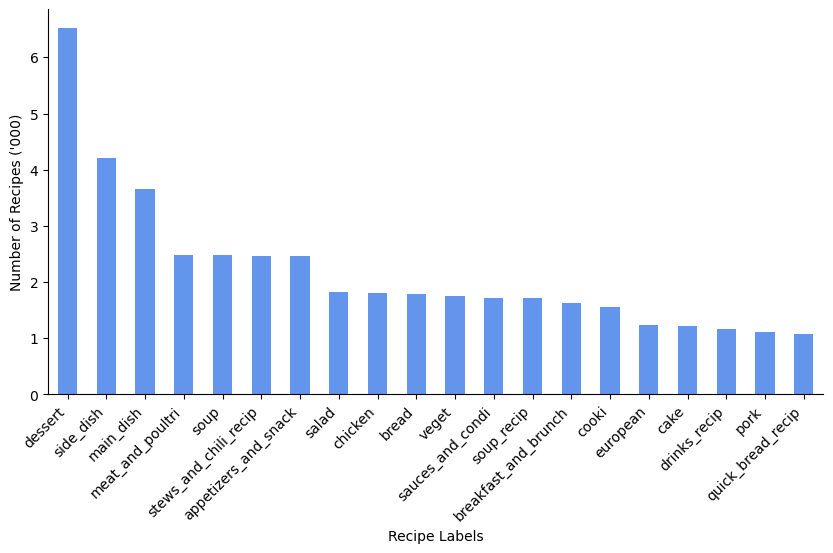

In [123]:
# Initiate figure object
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (10,5)
)

plot_series = vectorized_labels.sum()/1_000

plot_series.\
    sort_values(ascending = False).\
    head(20).plot(
        ax = ax,
        kind = "bar",
        legend = None,
        color = "cornflowerblue"
    )

plt.xticks(rotation = 45, ha = "right")
plt.xlabel("Recipe Labels")
plt.ylabel("Number of Recipes ('000)")

sns.despine()

plt.show()

## Bivariate Analysis

In [124]:
df = pd.concat(
    [
        df,
        vectorized_labels.loc
    ],
    axis = 1
)

In [125]:
df.head()

,recipe_url,title,label,rating_average,rating_count,_layer_dip_recip,acorn_squash,acorn_squash_side_dish_recip,adult_punch_recip,african,...,ziti_recip,zucchini,zucchini_appetizer_recip,zucchini_bread_recip,zucchini_cake_recip,zucchini_cookie_recip,zucchini_lasagna_recip,zucchini_muffin_recip,zucchini_salad_recip,zucchini_soup_recip
0,https://www.allrecipes.com/recipe/83646/corned...,Corned Beef Roast,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee...",4.4,68.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,https://www.allrecipes.com/recipe/158799/stout...,Stout-Braised Lamb Shanks,"['Cuisine', 'European', 'UK and Ireland', 'Iri...",4.5,45.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,https://www.allrecipes.com/recipe/8508920/miss...,Mississippi Chicken,"['Recipes', 'Meat and Poultry', 'Chicken']",4.8,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://www.allrecipes.com/recipe/255462/lasag...,Lasagna Flatbread,"['Recipes', 'Bread', 'Quick Bread Recipes']",4.5,42.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,https://www.allrecipes.com/recipe/245210/prosc...,Prosciutto-Wrapped Pork Tenderloin with Crispy...,"['Recipes', 'Meat and Poultry', 'Pork', 'Pork ...",4.8,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
top_20_labels = vectorized_labels.sum().sort_values(ascending = False).head(20).keys()

pd.melt(
    df.drop(columns = ["recipe_url", "label"]).loc[:,top_20_labels],
    id_vars = ["title", "rating_average", "rating_count"])

KeyError: "The following 'id_vars' are not present in the DataFrame: ['rating_average', 'rating_count', 'title']"

In [131]:
vectorized_labels.sum().sort_values(ascending = False).head(20).keys()

Index(['dessert', 'side_dish', 'main_dish', 'meat_and_poultri', 'soup',
       'stews_and_chili_recip', 'appetizers_and_snack', 'salad', 'chicken',
       'bread', 'veget', 'sauces_and_condi', 'soup_recip',
       'breakfast_and_brunch', 'cooki', 'european', 'cake', 'drinks_recip',
       'pork', 'quick_bread_recip'],
      dtype='object')